In [1]:
import os
import pickle
import sys
sys.path.append('..')
from mtDNAsim import *

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from ete3 import Tree
from Bio import Phylo
from io import StringIO
import re
import seaborn as sns

In [3]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [4]:
from tqdm.notebook import tqdm

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['font.size'] = 12
plt.rcParams['pdf.fonttype'] = 42

In [6]:
rf_data = pd.DataFrame()
path = '/data3/wangkun/mtsim_res/20240903/'
for model in os.listdir(path):
    if model == 'test':
        continue
    for simid in os.listdir(f'{path}/{model}'):
        try:
            rft = pd.read_csv(f'{path}/{model}/{simid}/rf_dist.txt', sep='\t')
            rf_data = pd.concat((rf_data, rft),ignore_index=True)
        except:
            pass

In [7]:
rf_data['seq'][rf_data['seq']!='_seq'] = 'no'

/tmp/ipykernel_119532/157854779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_data['seq'][rf_data['seq']!='_seq'] = 'no'


  0%|          | 0/9148 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:793: RuntimeWarning: invalid value encountered in divide
  freq_samp = rc/depth


  0%|          | 0/1040 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:793: RuntimeWarning: invalid value encountered in divide
  freq_samp = rc/depth


  0%|          | 0/1128 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:793: RuntimeWarning: invalid value encountered in divide
  freq_samp = rc/depth


  0%|          | 0/9148 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:793: RuntimeWarning: invalid value encountered in divide
  freq_samp = rc/depth


  0%|          | 0/1104 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:793: RuntimeWarning: invalid value encountered in divide
  freq_samp = rc/depth


  0%|          | 0/1069 [00:00<?, ?it/s]

/home/wangkun/mtDNA_simulation/scripts/../mtDNAsim/sim_utils.py:793: RuntimeWarning: invalid value encountered in divide
  freq_samp = rc/depth


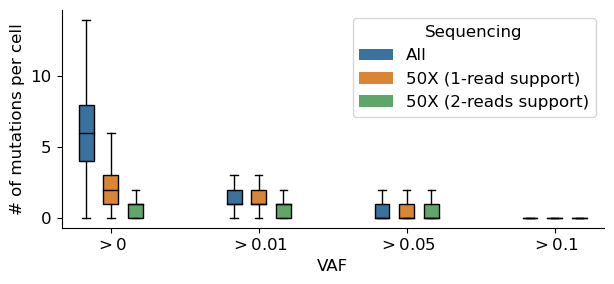

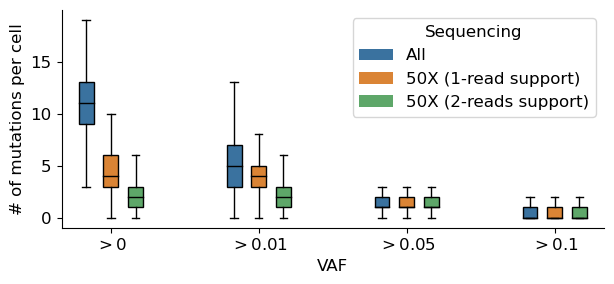

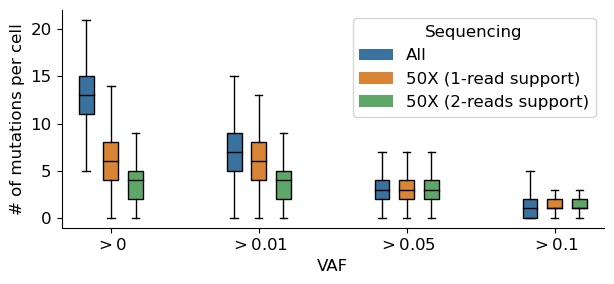

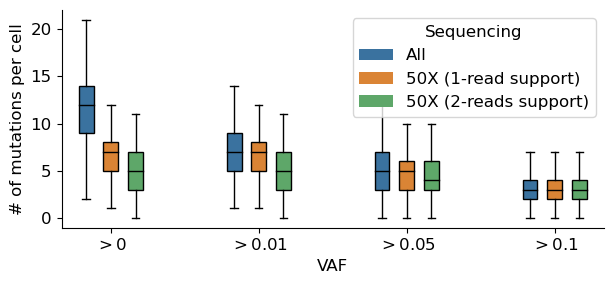

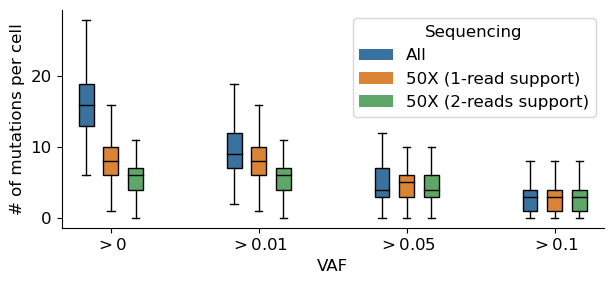

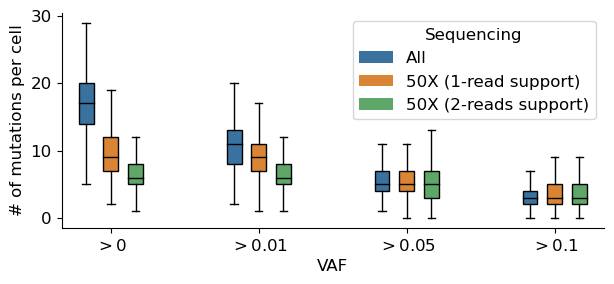

In [42]:

for path in ['/data3/wangkun/mtsim_res/20240903/mid_10/55486/',
             '/data3/wangkun/mtsim_res/20240903/mid_100/208057/']:
    if '_100' in path:
        hp = 100
    else:
        hp = 10
    for gen in [30, 130, 330]:
        mts = pickle.load(open(f'{path}mt_allmuts_{gen}.pkl', 'rb'))
        mt_freq = sparse_freq(mts)
        if gen == 30:
            tree = Phylo.read(f'{path}/gt_tree.nwk', 'newick')
            sel_cells = [i.name for i in tree.get_terminals()]
            mt_freq = mt_freq.loc[sel_cells]

        mt_freq_samp1, mt_freq_samp2 = sequence_sim(mt_freq, 50, n=2.5, min_reads=[1,2])

        num_vaf = []
        for i in [0,0.01,0.05,0.1]:
            for freq_i in (mt_freq, mt_freq_samp1, mt_freq_samp2):
                num_vaf.append(np.sum(freq_i>i, axis=1).to_numpy())
        fig, ax = plt.subplots(1, 1, figsize=(6.3, 3))
        medianprops = dict(color='black')
        bp = ax.boxplot(num_vaf, positions=[0.5,1,1.5,3.5,4,4.5,6.5,7,7.5,9.5,10,10.5],
                        widths=0.3, patch_artist=True, medianprops=medianprops,showfliers=False)
        ax.set_xlabel('VAF')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        colors=['#3a729f','#da8435', '#5ea769','#3a729f','#da8435','#5ea769','#3a729f','#da8435','#5ea769','#3a729f','#da8435','#5ea769']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        ax.set_ylabel('# of mutations per cell')
        legend_elements = []
        legend_elements.append(Patch(facecolor='#3a729f',label='All'))
        legend_elements.append(Patch(facecolor='#da8435',label='50X (1-read support)'))
        legend_elements.append(Patch(facecolor='#5ea769',label='50X (2-reads support)'))
        ax.legend(handles=legend_elements, title='Sequencing', loc=1)
        ax.set_xticks([1,4,7,10], 
                      ['$>0$', '$>0.01$', '$>0.05$', '$>0.1$'])
        plt.tight_layout()
        plt.savefig(f'../figs_bn/vaf_{gen}_heterp{hp}_r2.pdf')

In [43]:
from collections import Counter
def write_clone_color(path, header=False):
    '''
    header: for itol dataset
    '''
    for gen in ['_30', '_130', '_330']:
        treegt = Phylo.read(f'{path}/gt_tree{gen}.nwk'.replace('_30', ''), 'newick')
        if gen == '_30':
            for i in treegt.get_terminals():
                for j in treegt.get_path(i)[::-1][1:]:
                    if len(j.clades) == 1:
                        treegt.collapse(j)
            Phylo.write(treegt, f'{path}/gt_tree{gen}.nwk','newick')
        clones = [i.name.split('>')[0]+'>' for i in treegt.get_terminals()]
        clones_cnt = Counter(clones)
        # clones = list(set([i.name.split('>')[0]+'>' for i in treegt.get_terminals()]))
        # colors = ['#5D8AA8','#E32636','#FFBF00','#A4C639','#FBCEB1','#7FFFD4','#4B5320','#3B444B','#E9D66B','#B2BEB5','#FF9966','#6D351A','#007FFF','#89CFF0','#98777B','#DE5D83','#66FF00','#BF94E4','#FF007F','#004225','#FFC1CC','#800020']
        colors = ['#5BD17E','#D6D0FA','#FA937F','#C6E7CE','#E48DD0','#FFC33C','#8AE0DF','#82B329','#7475E6','#FBE2B4','#8F4851','#2040BD','#A5BFFA','#B500EB','#00992B','#724094','#FC6621','#CC2A27','#C2459F','#670755']        
        header = ['DATASET_COLORSTRIP','SEPARATOR SPACE','DATASET_LABEL label1','COLOR #ff0000','STRIP_WIDTH 120', 'DATA']
        # header = []
        if len(clones_cnt.keys()) <= 20:
            color_tab = dict(zip([i[0] for i in clones_cnt.most_common()], colors[:len(clones_cnt.keys())]))
            with open(f'{path}/tree_color{gen}.txt', 'w') as f:
                f.write('\n'.join(header))
                f.write('\n')
                for i in treegt.get_terminals():
                    f.write(f"{i.name} {color_tab[i.name.split('>')[0]+'>']}\n")
        else:
            progenitors = [treegt.root]
            iters = 0
            while len(progenitors)<20:
                iters += 1
                if iters > 100:
                    print('unsuccess')
                    break
                try:
                    progenitors.append(progenitors[0].clades[0])
                    progenitors.append(progenitors[0].clades[1])
                except:
                    pass
                progenitors.pop(0)
            cnt = [len(i.get_terminals()) for i in progenitors]
            with open(f'{path}/tree_color{gen}.txt', 'w') as f:
                f.write('\n'.join(header))
                f.write('\n')
                for ind, i in enumerate(np.argsort(cnt)[::-1]):
                    for j in progenitors[i].get_terminals():
                        f.write(f'{j.name} {colors[ind]}\n')


In [44]:
for path in ['/data3/wangkun/mtsim_res/20240903/mid_10/',
             '/data3/wangkun/mtsim_res/20240903/mid_100/']:
    for simid in tqdm(os.listdir(path)):
        write_clone_color(f'{path}/{simid}', header=False)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [51]:
def get_gt_dist(tree_mt, tree_gt, niter=100, verbose=False, copy=False):
    pairs = []
    cnt = 0
    if copy:
        tree_mt_copy = deepcopy(tree_mt)
    else:
        tree_mt_copy = tree_mt
    all_cells = tree_mt_copy.get_terminals()
    for i in tree_mt_copy.get_terminals():
        i.branch_length=1
    for i in tree_mt_copy.get_nonterminals():
        i.branch_length=1
    if verbose:
        pbar = tqdm(total=niter)

    while cnt < niter:
        c1 = all_cells[np.random.choice(range(len(all_cells)))]
        for anc in tree_mt_copy.get_path(c1)[::-1][1:]:
            if len(anc.get_terminals())<2:
                continue
            siss, dists = [], []
            for sis in anc.get_terminals():
                siss.append(sis)
                dists.append(tree_mt_copy.distance(c1, sis))

            c2 = siss[np.where(np.argsort(dists)==len(dists)-1)[0][0]]
            pairs.append((c1.name, c2.name))
            cnt += 1
            if verbose:
                pbar.update(1)
            break
            
    dist_gt = []
    for i in pairs:
        c1, c2 = tree_gt.find_any(i[0]), tree_gt.find_any(i[1])
        dist_gt.append(tree_gt.distance(c1, c2))
    return np.array(dist_gt)/2

In [56]:
terminal_bl_data = dict()
for path in ['/data3/wangkun/mtsim_res/20240903/mid_10/55486/',
             '/data3/wangkun/mtsim_res/20240903/mid_100/208057/']:
    for gen in [30, 130, 330]: 
        tree_gt = Phylo.read(f'{path}/gt_tree_{gen}.nwk', 'newick')
        tree_mt = Phylo.read(f'{path}/mt_allmuts_{gen}_0.phy_nj.nwk', 'newick')
        tree_ndna = Phylo.read(f'{path}/dna_mut_{gen}.phy_nj.nwk'.replace('_30', ''), 'newick')
        tree_mt1 = Phylo.read(f'{path}/mt_allmuts_{gen}_0.01.phy_nj.nwk', 'newick')
        tree_mt_seq1 = Phylo.read(f'{path}/mt_allmuts_{gen}_0_seq1.phy_nj.nwk', 'newick')
        tree_mt1_seq1 = Phylo.read(f'{path}/mt_allmuts_{gen}_0.01_seq1.phy_nj.nwk', 'newick')
        tree_mt_seq2 = Phylo.read(f'{path}/mt_allmuts_{gen}_0_seq2.phy_nj.nwk', 'newick')
        tree_mt1_seq2 = Phylo.read(f'{path}/mt_allmuts_{gen}_0.01_seq2.phy_nj.nwk', 'newick')

        niter = 500
        dist_mt10 = get_gt_dist(tree_mt, tree_gt, niter=niter)
        dist_ndna10 = get_gt_dist(tree_ndna, tree_gt, niter=niter)
        dist_mt110 = get_gt_dist(tree_mt1, tree_gt, niter=niter)
        dist_mt_seq110 = get_gt_dist(tree_mt_seq1, tree_gt, niter=niter)
        dist_mt1_seq110 = get_gt_dist(tree_mt1_seq1, tree_gt, niter=niter)
        dist_mt_seq210 = get_gt_dist(tree_mt_seq2, tree_gt, niter=niter)
        dist_mt1_seq210 = get_gt_dist(tree_mt1_seq2, tree_gt, niter=niter)
        dist_gt10 = get_gt_dist(tree_gt, tree_gt, niter=niter, copy=True)
        dist_random10 = []
        cells_gt = tree_gt.get_terminals()
        for _ in range(niter):
            c1, c2 = np.random.choice(range(len(cells_gt)), 2, replace=False)
            dist_random10.append(tree_gt.distance(cells_gt[c1], cells_gt[c2])/2)
            
        if 'mid_100' in path:
            terminal_bl_data[f'100_{gen}'] = [dist_gt10, dist_ndna10, dist_mt10, dist_mt_seq110, dist_mt_seq210, dist_mt110, dist_mt1_seq110, dist_mt1_seq210, dist_random10]
        else:
            terminal_bl_data[f'10_{gen}'] = [dist_gt10, dist_ndna10, dist_mt10, dist_mt_seq110, dist_mt_seq210, dist_mt110, dist_mt1_seq110, dist_mt1_seq210, dist_random10]
       

In [57]:
pickle.dump(terminal_bl_data, open('../figs_bn/terminal_bl_data.pkl', 'wb'))

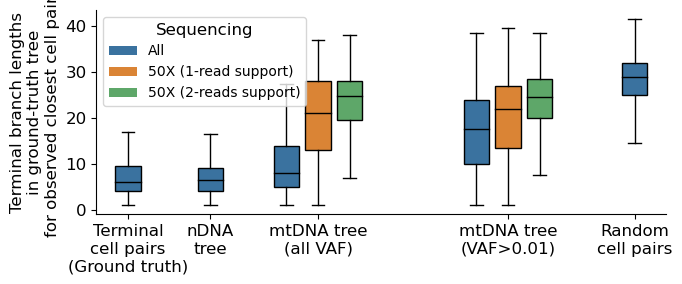

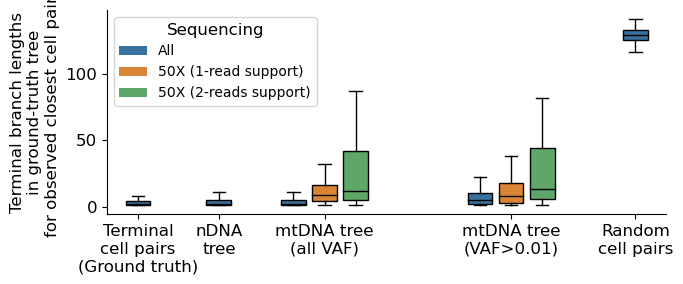

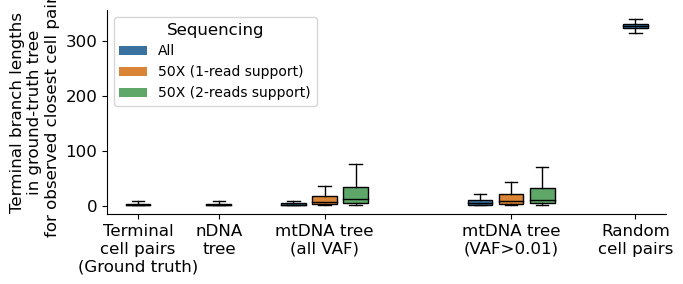

In [58]:
for heterp in [10, 100]:
    for gen in [30, 130, 330]:
        fig, ax = plt.subplots(figsize=(7,3))
        bp = ax.boxplot(terminal_bl_data[f'{heterp}_{gen}'], widths=0.4, patch_artist=True, medianprops=medianprops,showfliers=False,
                        positions=[1,2.3,3.5,4,4.5,6.5,7,7.5,9]
                       )

        colors = ['#3a729f','#3a729f','#3a729f','#da8435', '#5ea769','#3a729f','#da8435', '#5ea769', '#3a729f'] 
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        legend_elements = []
        legend_elements.append(Patch(facecolor='#3a729f',label='All'))
        legend_elements.append(Patch(facecolor='#da8435',label='50X (1-read support)'))
        legend_elements.append(Patch(facecolor='#5ea769',label='50X (2-reads support)'))
        ax.legend(handles=legend_elements, title='Sequencing', loc=2, fontsize=10)

        ax.set_xticks([1,2.3,4, 7, 9], 
                      ['Terminal\ncell pairs\n(Ground truth)','nDNA\ntree','mtDNA tree\n(all VAF)', 'mtDNA tree\n(VAF>0.01)', 'Random\ncell pairs'])
        ax.set_ylabel('Terminal branch lengths\nin ground-truth tree\nfor observed closest cell pairs')
        # ax.set_title('Root cell heteroplasmy = 10')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.tight_layout()
        plt.savefig(f'../figs_bn/terminal_bl_{gen}_h{heterp}_r2.pdf')

In [59]:
def clone_aggregation_score(tree_file, state_file):
    with open(state_file, 'r') as f:
        color_file = f.readlines()
    cell_states = dict()
    for i in color_file:
        try:
            cell, state = i.split(' ')
            cell_states[cell] = state.strip()
        except:
            pass
    tree_mt = Phylo.read(tree_file, 'newick') 
    state_mt = []
    for i in tree_mt.get_terminals():
        try:
            state_mt.append(cell_states[i.name])
        except:
            state_mt.append('0')
    state_diff_mt = 0
    for i, j in zip(state_mt[:-1], state_mt[1:]):
        if i!=j:
            state_diff_mt += 1
    return 1-np.log(len(set(state_mt))/state_diff_mt)/np.log(len(set(state_mt))/len(state_mt))

In [60]:
cas_100 = []
path = '/data3/wangkun/mtsim_res/20240903/mid_100/'
for simid in tqdm(os.listdir(path)):
    cast = []
    for gen in [30, 130, 330]:
        cast.append(clone_aggregation_score(f'{path}/{simid}/dna_mut_{gen}.phy_nj.nwk'.replace('_30', ''), f'{path}/{simid}/tree_color_{gen}.txt'))
        cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        for read in range(1,3):
            cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0_seq{read}.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        # cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0_seq2.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0.01.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        for read in range(1,3):
            cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0.01_seq{read}.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        # cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0.01_seq2.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
    cas_100.append(cast)
    
cas_10 = []
path = '/data3/wangkun/mtsim_res/20240903/mid_10/'
for simid in tqdm(os.listdir(path)):
    cast = []
    for gen in [30, 130, 330]:
        cast.append(clone_aggregation_score(f'{path}/{simid}/dna_mut_{gen}.phy_nj.nwk'.replace('_30', ''), f'{path}/{simid}/tree_color_{gen}.txt'))
        cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        for read in range(1,3):
            cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0_seq{read}.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        # cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0_seq2.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0.01.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        for read in range(1,3):
            cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0.01_seq{read}.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
        # cast.append(clone_aggregation_score(f'{path}/{simid}/mt_allmuts_{gen}_0.01_seq2.phy_nj.nwk', f'{path}/{simid}/tree_color_{gen}.txt'))
    cas_10.append(cast)
cas_10 = pd.DataFrame(cas_10)
cas_100 = pd.DataFrame(cas_100)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

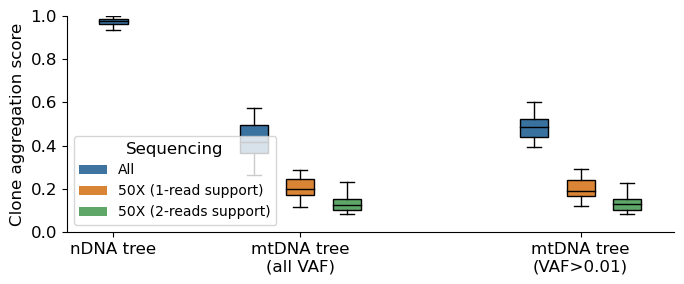

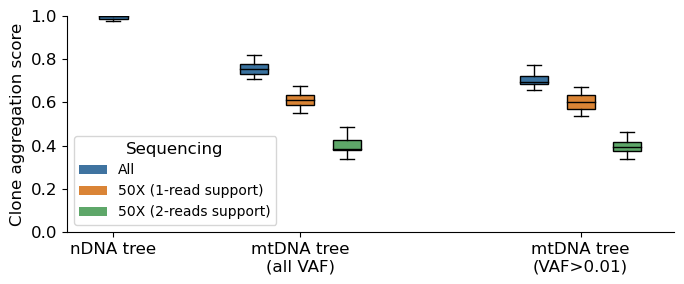

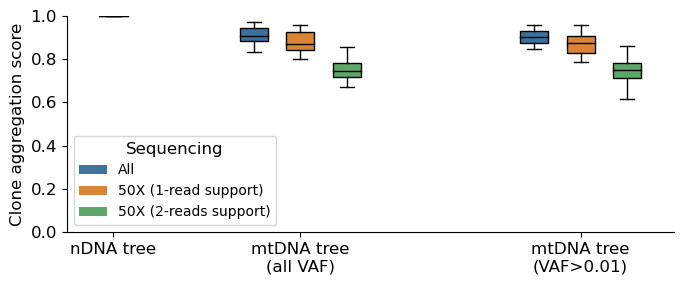

In [61]:
for i,gen in zip(range(3), [30,130,330]):
    fig, ax = plt.subplots(figsize=(7,3))
    medianprops = dict(color='black')
    bp = ax.boxplot(cas_10.iloc[:,i*7:(i+1)*7], positions=[0, 1.5,2,2.5,4.5,5,5.5],
                    widths=0.3, patch_artist=True, medianprops=medianprops,showfliers=False)
    colors=['#3a729f','#3a729f','#da8435','#5ea769', '#3a729f','#da8435', '#5ea769']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    legend_elements = []
    legend_elements.append(Patch(facecolor='#3f73a0',label='All'))
    legend_elements.append(Patch(facecolor='#da8436',label='50X (1-read support)'))
    legend_elements.append(Patch(facecolor='#5ea769',label='50X (2-reads support)'))
    ax.legend(handles=legend_elements, title='Sequencing', loc=3, fontsize=10)
    ax.set_ylabel('Clone aggregation score')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([0,2, 5], 
                  ['nDNA tree','mtDNA tree\n(all VAF)', 'mtDNA tree\n(VAF>0.01)'])
    ax.set_ylim((0,1))
    plt.tight_layout()
    plt.savefig(f'../figs_bn/cas_h10_{gen}_2r.pdf')

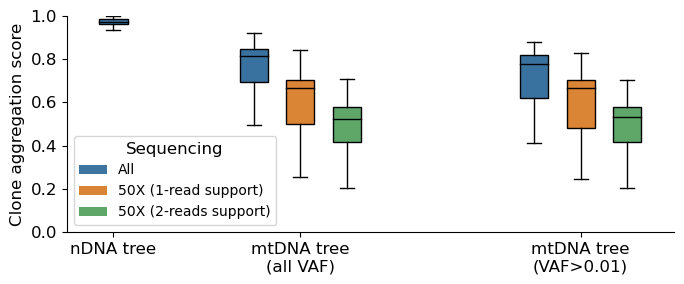

In [62]:
for i,gen in zip(range(3), [30,130,330]):
    fig, ax = plt.subplots(figsize=(7,3))
    medianprops = dict(color='black')
    bp = ax.boxplot(cas_100.iloc[:,i*7:(i+1)*7], positions=[0, 1.5,2,2.5,4.5,5,5.5],
                    widths=0.3, patch_artist=True, medianprops=medianprops,showfliers=False)
    colors=['#3a729f','#3a729f','#da8435','#5ea769', '#3a729f','#da8435', '#5ea769']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    legend_elements = []
    legend_elements.append(Patch(facecolor='#3f73a0',label='All'))
    legend_elements.append(Patch(facecolor='#da8436',label='50X (1-read support)'))
    legend_elements.append(Patch(facecolor='#5ea769',label='50X (2-reads support)'))
    ax.legend(handles=legend_elements, title='Sequencing', loc=3, fontsize=10)
    ax.set_ylabel('Clone aggregation score')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([0,2, 5], 
                  ['nDNA tree','mtDNA tree\n(all VAF)', 'mtDNA tree\n(VAF>0.01)'])
    ax.set_ylim((0,1))
    plt.tight_layout()
    plt.savefig(f'../figs_bn/cas_h100_{gen}_2r.pdf')

In [63]:
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/home/wangkun/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailabl

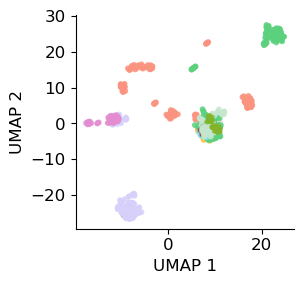

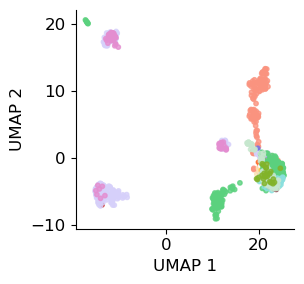

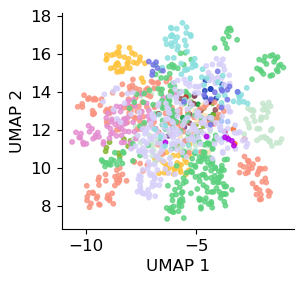

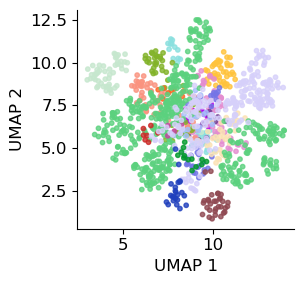

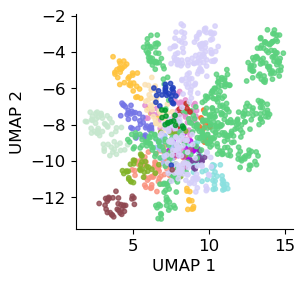

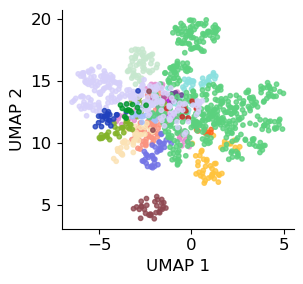

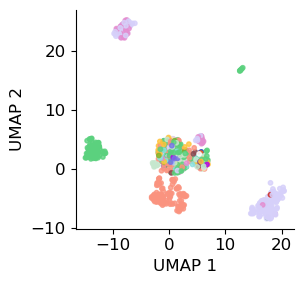

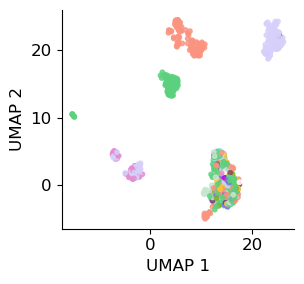

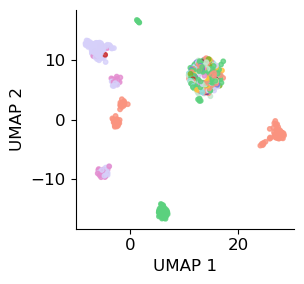

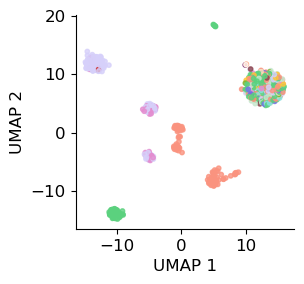

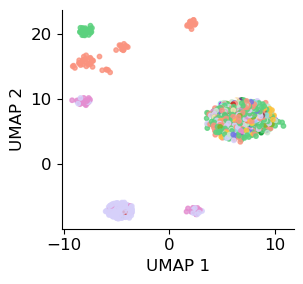

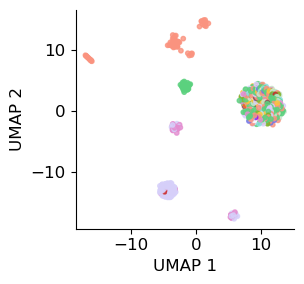

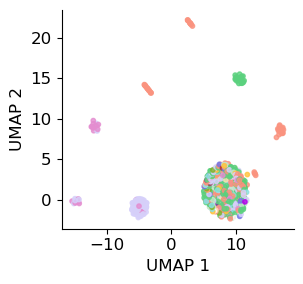

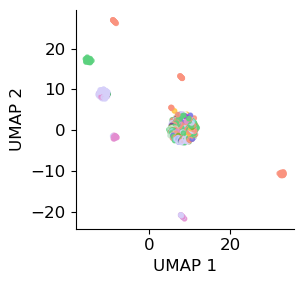

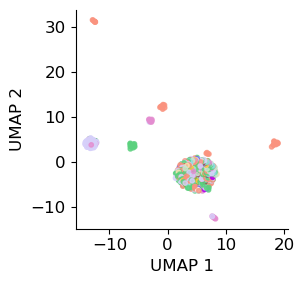

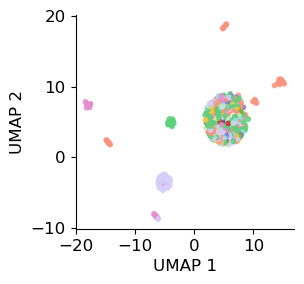

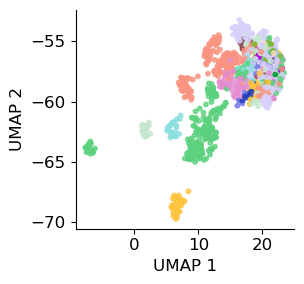

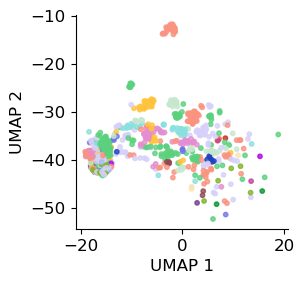

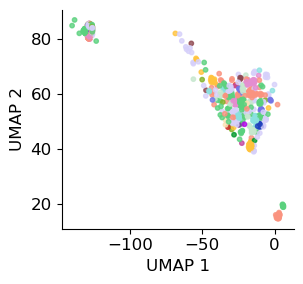

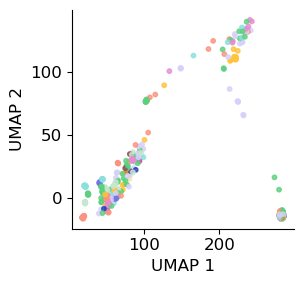

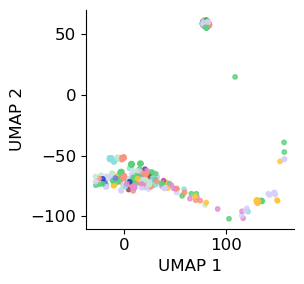

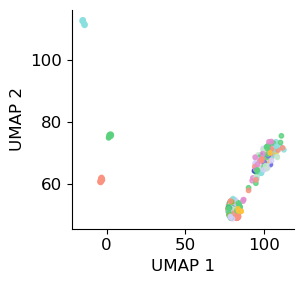

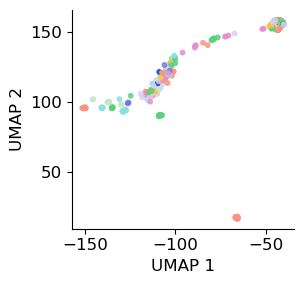

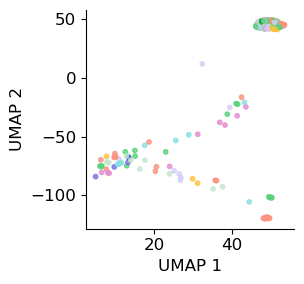

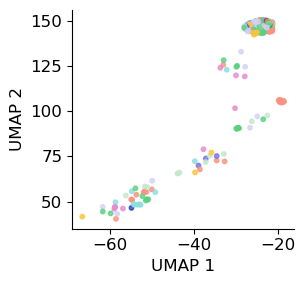

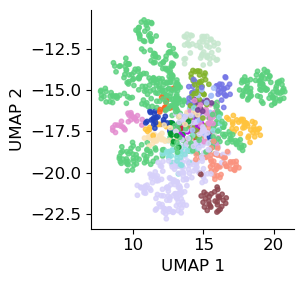

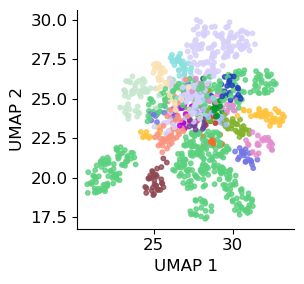

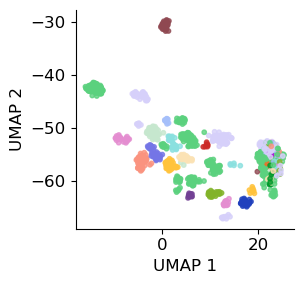

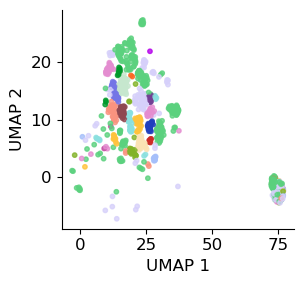

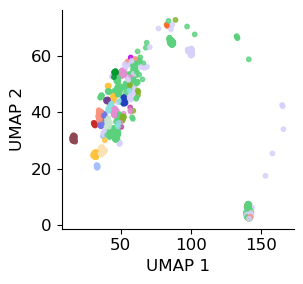

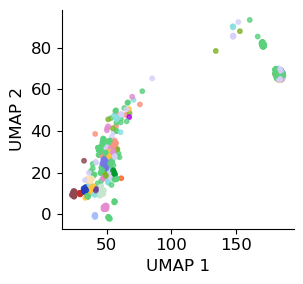

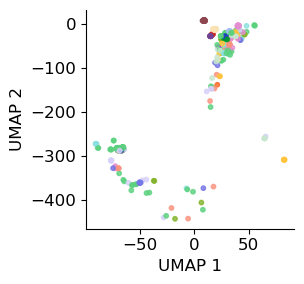

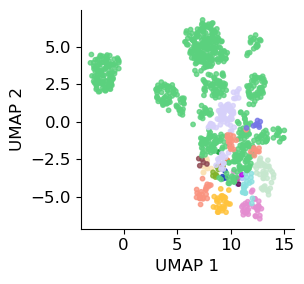

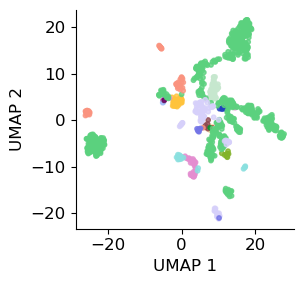

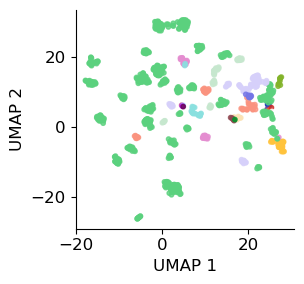

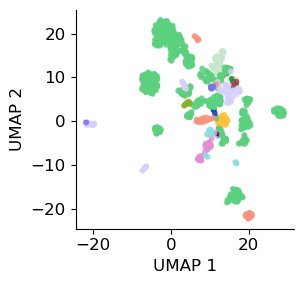

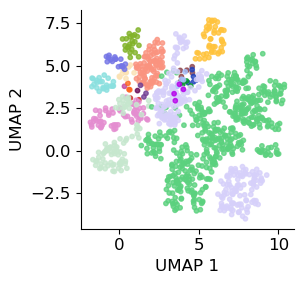

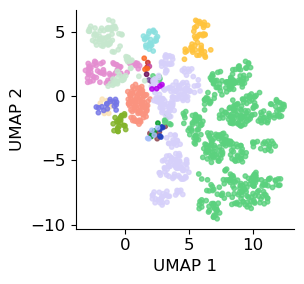

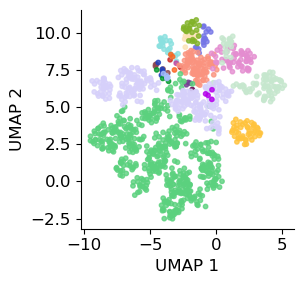

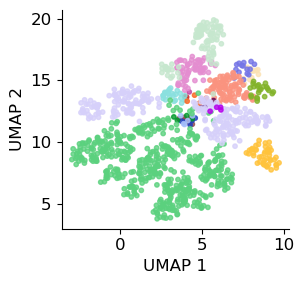

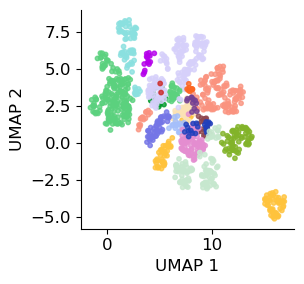

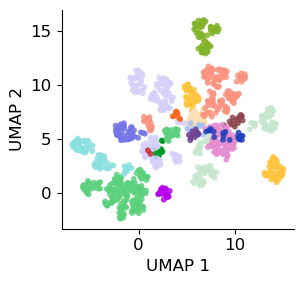

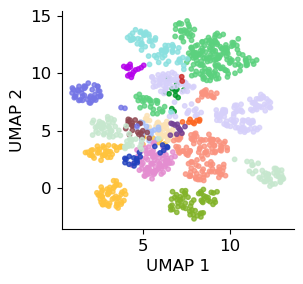

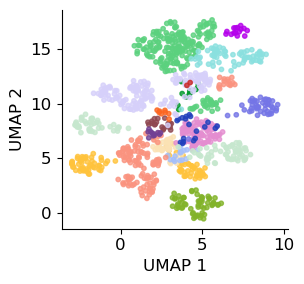

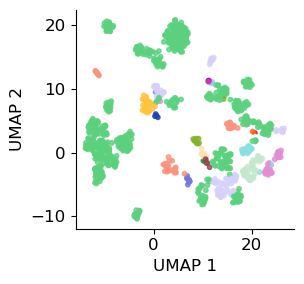

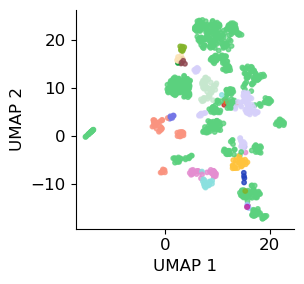

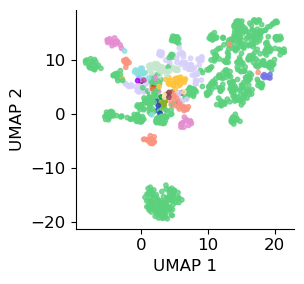

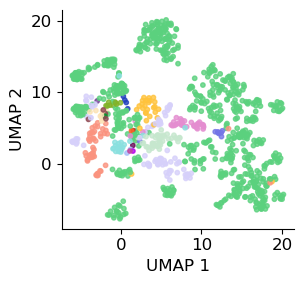

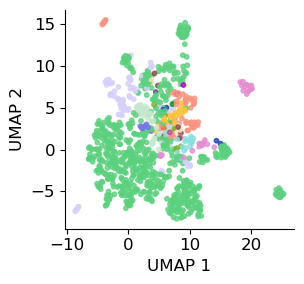

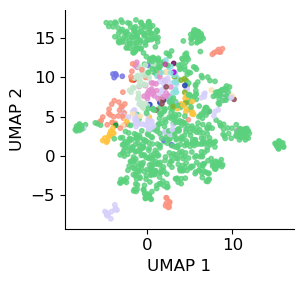

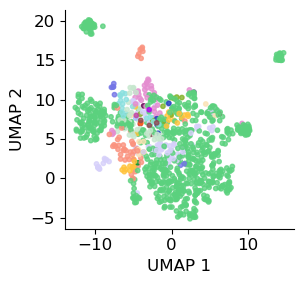

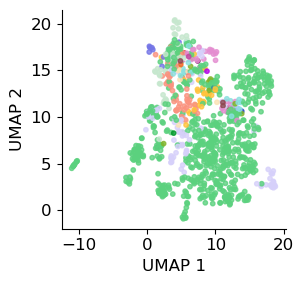

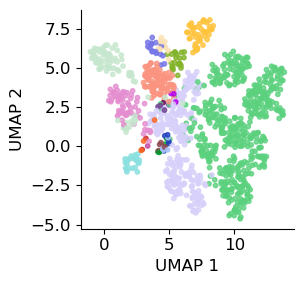

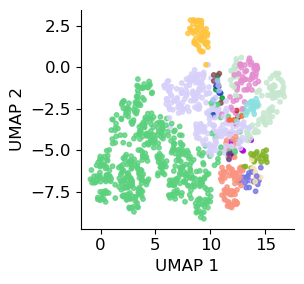

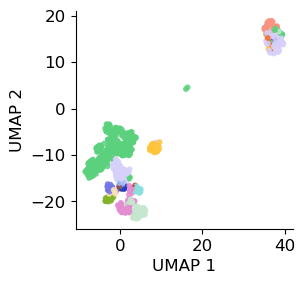

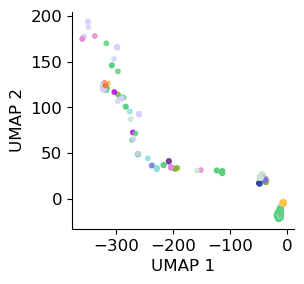

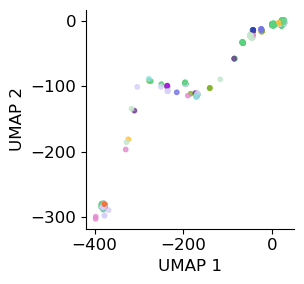

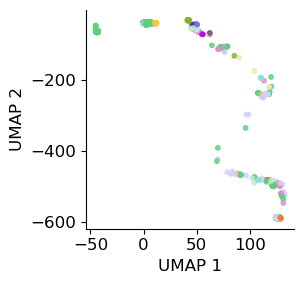

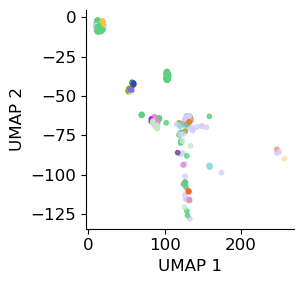

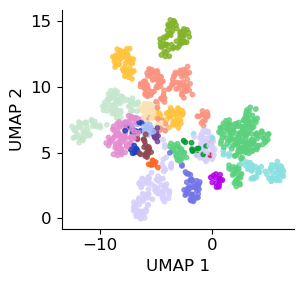

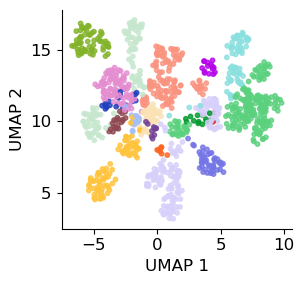

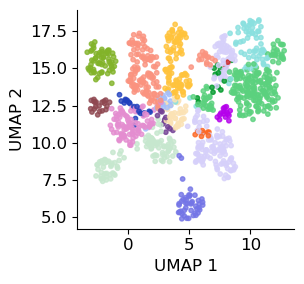

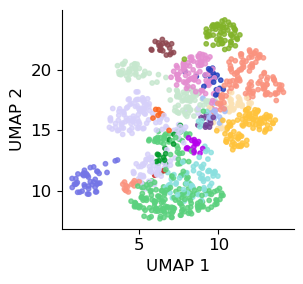

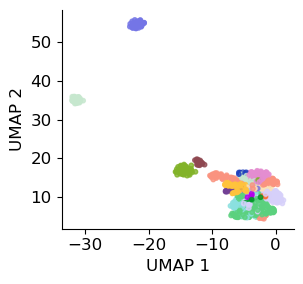

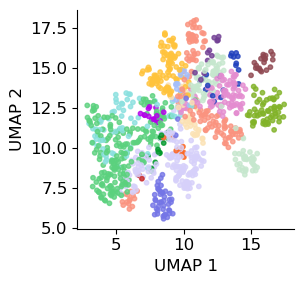

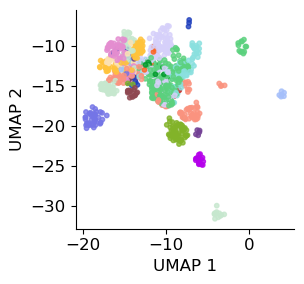

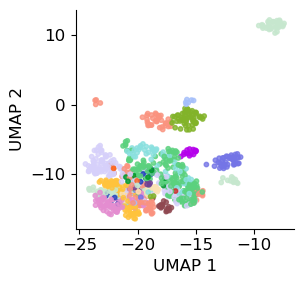

In [64]:
for path in ['/data3/wangkun/mtsim_res/20240903/mid_10/55486/',
             '/data3/wangkun/mtsim_res/20240903/mid_100/208057/']:
    for file in [i for i in os.listdir(path) if i[-3:] =='phy']:
        if 'dna' in file:
            continue
        if '_30' in file:
            color_file = 'tree_color_30.txt'
        elif '_130' in file:
            color_file = 'tree_color_130.txt'
        else:
            color_file = 'tree_color_330.txt'
        with open(f'{path}/{color_file}', 'r') as f:
            colors = f.readlines()
        color_dict = dict()
        for i in colors[6:]:
            cell, col = i.split(' ')
            color_dict[cell] = col.strip()

        with open(f'{path}/{file}', 'r') as f:
            seqs = f.readlines()
        seqs = seqs[1:]
        translation_table = str.maketrans({'A': '1', 'G': '0'})
        muttab = []
        cell_names = []
        for i in seqs:
            muttab.append(list(i.translate(translation_table).split(' ')[1].strip()))
            cell_names.append(i.split(' ')[0])
        mutdf = pd.DataFrame(np.array(muttab).astype(int), index=cell_names)
        # X_pc100 = PCA(n_components=100).fit_transform(mutdf)
        if ('_30' in file) and (file != 'mt_allmuts_30_0.phy'):
            mut_umap = umap.UMAP(n_components=2, min_dist=1, n_neighbors=5, metric='hamming').fit_transform(mutdf)
        else:
            mut_umap = umap.UMAP(n_components=2, min_dist=1, n_neighbors=100, metric='hamming').fit_transform(mutdf)
        # mut_umap = TSNE(n_components=2, perplexity=500).fit_transform(mutdf)
        fig, ax = plt.subplots(1, 1, figsize=(3.2,3))
        scat_color = []
        for i in mutdf.index:
            try:
                scat_color.append(color_dict[i])
            except:
                scat_color.append('#FFFFFF')
        ax.scatter(mut_umap[:,0], mut_umap[:,1], s=10, alpha=0.8,c=scat_color)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_xlabel('UMAP 1')
        ax.set_ylabel('UMAP 2')
        plt.tight_layout()
        if '_100' in path:
            plt.savefig(f'../figs_bn/umap_100/{file}.pdf')
        else:
            plt.savefig(f'../figs_bn/umap_10/{file}.pdf')